In [113]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
pd.options.display.max_rows =12

In [114]:
fire = pd.read_csv("caliwildfire.csv" , error_bad_lines=False)

C:\Users\HP RBZ\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\HP RBZ\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,19,32,45,58,71,84,97,110,123,136,149,162,175,188,201,214,227,240,253,266,279,292,305,318,331,344,357,370,383,396,409,422,435,448,461,474,487,500,513,526,539,552,565,578,591,604,617,630,643,656,669,682,695,708,721,734,747,760,773,786,799,812,825,838,851,864,877,890,903,916,929,942,955,968,981,994,1007,1020,1033,1046,1059,1072,1085,1098,1111,1124,1137,1150,1163,1176,1189,1202,1215,1228,1241,1254,1267,1280,1293,1306,1319,1332,1345,1358,1371,1384,1397,1410,1423,1436,1449,1462,1475,1488,1501,1514,1527,1540,1553,1566,1579,1592,1605,1618,1631,1644,1657,1670,1683,1696,1709,1722,1735,1748,1761,1773,1785,1797,1809,1822,1835,1848,1861,1874,1887,1900,191

In [115]:
fire.head()

,Unnamed: 0,_id,Event,Latitude,Longitude,summary_336,precipType_336,temperature_336,apparentTemperature_336,dewPoint_336,...,humidity359,pressure359,windSpeed359,windGust359,windBearing359,cloudCover359,uvIndex359,visibility359,Size,Costs
0,0,"ObjectId(""5caeb38ca6e44a5b0027cc15"")",CA-CNF-000102,33.6681,-117.50139,Partly Cloudy,rain,46.87,46.87,45.21,...,0.72,1023.10,0.28,3.68,47.0,0.28,0.0,3.67,100.0,285000.0
1,1,"ObjectId(""5caeb38ca6e44a5b0027cc16"")",CA-MVU-955,33.0333,-116.83389,Clear,NaN,42.15,42.15,16.90,...,0.93,1015.29,1.74,1.74,142.0,1.00,0.0,10.00,25.0,NaN
2,2,"ObjectId(""5caeb38ca6e44a5b0027cc17"")",CA-MVU-001494,32.1169,-116.68583,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.0,NaN
3,3,"ObjectId(""5caeb38ca6e44a5b0027cc18"")",CA-RRU-009418,33.6172,-116.15083,Overcast,rain,55.44,55.44,20.01,...,0.44,1022.29,3.87,12.01,254.0,0.00,0.0,9.17,15.0,NaN
4,4,"ObjectId(""5caeb38ca6e44a5b0027cc19"")",CA-RRU-10403,34.8678,-117.66306,Clear,rain,43.39,39.90,28.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400.0,689386.0


In [116]:
#check out for missing data
fire.isnull().sum() * 100 / len(fire)

Unnamed: 0        0.000000
_id               0.000000
Event             0.000000
Latitude          0.000000
Longitude         0.000000
                   ...    
cloudCover359    27.210884
uvIndex359       13.343799
visibility359    25.850340
Size              0.000000
Costs            88.173731
Length: 9104, dtype: float64

In [117]:
# costs column has more than 50%  of missing data and it's not an important column so we can drop it and dropping some useless columns
fire = fire.drop(['Unnamed: 0','Costs'],axis=1)


In [118]:
#dropping columns that are not useful 
fire = fire[fire.columns.drop(list(fire.filter(regex='windGust')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='visibility')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='cloudCover')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='windBearing')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='uvIndex')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='summary')))]
fire = fire[fire.columns.drop(list(fire.filter(regex='precipType')))]



In [119]:
fire.shape

(1911, 4271)

In [120]:
x = fire.isnull().sum() * 100 / len(fire)
x.sort_values(ascending = False)


pressure359    31.187860
pressure358    29.931973
pressure357    29.565672
pressure356    29.094715
pressure_66    28.937729
                 ...    
_id             0.000000
Event           0.000000
Longitude       0.000000
Latitude        0.000000
Size            0.000000
Length: 4271, dtype: float64

In [121]:
fire= fire.dropna()
fire= fire.reset_index(drop=True)
fire.shape

(681, 4271)

In [122]:
# check for duplicates 
fire.duplicated().any()

False

In [123]:
fire.dtypes

_id                 object
Event               object
Latitude           float64
Longitude          float64
temperature_336    float64
                    ...   
dewPoint359        float64
humidity359        float64
pressure359        float64
windSpeed359       float64
Size               float64
Length: 4271, dtype: object

Visualization via heatmap

In [124]:
map = folium.Map(location=[37.7749, -122.4194],
                    zoom_start = 8) 

# Filtering heatdata (displaying only above average temp)
average_size=np.mean(fire['Size'])
heat_df = fire[fire['Size']>=average_size]
heat_df = fire[['Latitude', 'Longitude']]
heat_data = [[row['Latitude'],row['Longitude']] for index , row in heat_df.iterrows()]


HeatMap(heat_data).add_to(map)


map

<h1>Data Transformation</h1>

C:\Users\HP RBZ\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Histogram of Fire Sizes'),
 Text(0.5, 0, 'Fire Size (log acres)')]

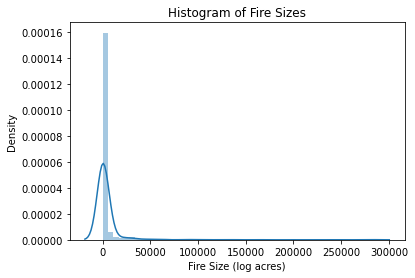

In [125]:
sns.distplot(fire.Size).set(title= 'Histogram of Fire Sizes', xlabel= 'Fire Size (log acres)')

In [126]:
#Add column of log sizes (Log transformation)
log_sizes = np.log(fire.Size)
fire['log_sizes'] = log_sizes
fire['log_sizes']

0      4.605170
1      3.218876
2      6.733402
3      6.793466
4      2.708050
         ...   
676    8.707648
677    6.045005
678    7.209340
679    5.579730
680    8.125631
Name: log_sizes, Length: 681, dtype: float64

C:\Users\HP RBZ\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Histogram of Fire Sizes'),
 Text(0.5, 0, 'Fire Size (log acres)')]

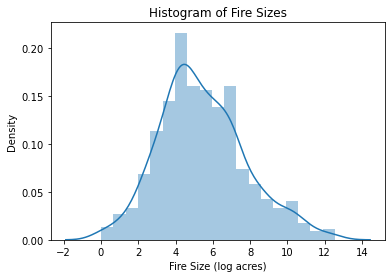

In [127]:
sns.distplot(log_sizes).set(title= 'Histogram of Fire Sizes', xlabel= 'Fire Size (log acres)')

<h1>Data enrichement </h1>

In [128]:
#Run a for loop to add a label to each fire based on government classification of fire sizes
fire_category = []
for size in fire.Size:
    if float(size)<=0.25:
        fire_category.append('class_a')
    elif float(size) <10 and float(size) >0.25:
        fire_category.append('class_b')
    elif float(size) >=10 and float(size) <100:
        fire_category.append('class_c')
    elif float(size) >=100 and float(size) <300:
        fire_category.append('class_d')
    elif float(size) >= 300 and float(size) <1000:
        fire_category.append('class_e')
    elif float(size) >= 1000 and float(size) <5000:
        fire_category.append('class_f')
    elif float(size) >=5000:
        fire_category.append('class_g') 



In [129]:
#Add column with classification of fire sizes
fire['size_category'] = fire_category
fire.size_category

0      class_d
1      class_c
2      class_e
3      class_e
4      class_c
        ...   
676    class_g
677    class_e
678    class_f
679    class_d
680    class_f
Name: size_category, Length: 681, dtype: object

In [130]:
#Create a list of features (might use this string for a future for loop or a function -josh)
features = ['temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed']

#first create intervals to combine data between certain hours
bins = np.arange(0, 697, 24)

cleaned_df = fire[['_id','Event', 'Latitude','Longitude','Size','log_sizes','size_category']]

#Create a list of strings that marks each day to add to the word 'temperature'
days = ['_14','_13', '_12', '_11', '_10', '_9', '_8', '_7', '_6', '_5', '_4', '_3', '_2', '_1',
'0', '1', '2', '3','4','5','6','7','8','9','10','11','12','13','14']

for feature in features:
    feature_by_day = [] #empty list to store all info for each day
    for i in np.arange(len(bins)-1):
        feature_df = fire.filter(regex=feature)
        feature_daily_avg = np.array(feature_df.iloc[:, bins[i]:bins[i+1]].mean(axis=1))
        feature_by_day.append(feature_daily_avg)
        for j in np.arange(len(feature_by_day)):
            word = feature + days[j]
            cleaned_df[word] = feature_by_day[j]
cleaned_df.head()

C:\Users\HPRBZ~1\AppData\Local\Temp/ipykernel_7644/893860414.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[word] = feature_by_day[j]
C:\Users\HPRBZ~1\AppData\Local\Temp/ipykernel_7644/893860414.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df[word] = feature_by_day[j]


,_id,Event,Latitude,Longitude,Size,log_sizes,size_category,temperature_14,temperature_13,temperature_12,...,windSpeed5,windSpeed6,windSpeed7,windSpeed8,windSpeed9,windSpeed10,windSpeed11,windSpeed12,windSpeed13,windSpeed14
0,"ObjectId(""5caeb38ca6e44a5b0027cc15"")",CA-CNF-000102,33.6681,-117.50139,100.0,4.605170,class_d,48.221250,52.325833,55.353750,...,3.646667,2.427500,4.275833,1.949583,2.096250,1.935833,1.428750,2.269583,1.633333,1.618333
1,"ObjectId(""5caeb38ca6e44a5b0027cc16"")",CA-MVU-955,33.0333,-116.83389,25.0,3.218876,class_c,48.305833,46.069583,44.835417,...,1.526667,1.640417,1.833333,5.261250,4.941250,1.846250,2.011250,7.476250,5.292083,2.992083
2,"ObjectId(""5caeb38ca6e44a5b0027cc1b"")",CA-BDU-2403,37.3683,-118.35833,840.0,6.733402,class_e,40.872500,41.335833,49.464583,...,3.337500,2.846250,5.654583,4.394583,2.933750,2.271250,2.413333,2.819167,5.687500,6.950417
3,"ObjectId(""5caeb38ca6e44a5b0027cc27"")",CA-RRU-29527,33.8692,-117.68361,892.0,6.793466,class_e,55.987500,59.727083,60.797917,...,5.224583,4.270417,2.530000,4.327917,5.611250,3.257917,3.257083,3.121667,2.863750,2.850417
4,"ObjectId(""5caeb38ca6e44a5b0027cc2c"")",CA-MVU-003100,32.8689,-116.86667,15.0,2.708050,class_c,54.468750,53.435833,55.019167,...,3.899167,4.002500,3.761667,6.027083,3.868333,2.800000,3.557500,3.774583,4.250417,3.922083


In [131]:
cleaned_df.shape

(681, 181)

In [132]:
cleaned_df.to_csv('cleaned_wildfire_data.csv')